# Recurrent Neural Network

## Part 1 - Data Preprocessing

### Importing the libraries

In [85]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importing the training set

In [86]:
# Read the data frame
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')

# Convert the value to predict in numpy array
training_set = dataset_train.iloc[:, 1:2].values
print(dataset_train.head(5))

       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800


### Feature Scaling

In [87]:
# Use the normalization transformation to the nparray (MinMaxScaler)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(training_set)
training_set = scaler.transform(training_set)

### Creating a data structure with 60 timesteps and 1 output

In [88]:
# For each financial day, you will take into account the stock price of the 60
# previous days to predict the future stock price
# build X_train and y_train according to this
# YOUR CODE
X_train = []
y_train = []
for i in range(60, len(training_set)):
    X_train.append(training_set[i-60:i, 0])
    y_train.append(training_set[i, 0])

# X_train and y_train must be numpy array
# YOUR CODE
X_train, y_train = np.array(X_train), np.array(y_train)

In [89]:
print(X_train[0])
print(y_train[0])

[0.08581368 0.09701243 0.09433366 0.09156187 0.07984225 0.0643277
 0.0585423  0.06568569 0.06109085 0.06639259 0.0614257  0.07474514
 0.02797827 0.02379269 0.02409033 0.0159238  0.01078949 0.00967334
 0.01642607 0.02100231 0.02280676 0.02273235 0.02810849 0.03212665
 0.0433812  0.04475779 0.04790163 0.0440695  0.04648783 0.04745517
 0.04873875 0.03936305 0.04137213 0.04034898 0.04784582 0.04325099
 0.04356723 0.04286033 0.04602277 0.05398467 0.05738894 0.05714711
 0.05569611 0.04421832 0.04514845 0.04605997 0.04412531 0.03675869
 0.04486941 0.05065481 0.05214302 0.05612397 0.05818885 0.06540665
 0.06882953 0.07243843 0.07993526 0.07846566 0.08034452 0.08497656]
0.08627874097775134


### Building the dataloader

In [90]:
# Convert your data to PyTorch float tensors
# YOUR CODE
X_train = torch.tensor(X_train,dtype=torch.float32)
y_train = torch.tensor(y_train,dtype=torch.float32)


# Build the DataLoader with batch of size 32
# YOUR CODE
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train.unsqueeze(2), y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


## Part 2 - Building and Training the RNN

### Define the RNN model

In [91]:
# Build a class for your model
# dim caché = arg à foutre en propriété de la classe
# un layer linear en sortie
# The model will contains LSTM layers with 50 memory units (or neurons) and two layers by default,
# Set a dropout regularisation with a rate of 0.2
# Finally add the output Linear layer, the output will be of one dimension (one stock price predicted)

# YOUR CODE
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=100):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size,dropout=0.2,num_layers=2,batch_first=True)
        self.linear1 = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, x):
        x,_ = self.lstm1(x)
        x = x[:, -1, :]
        x = self.linear1(x)
        return x
    

### Instantiate the model, loss function, and optimizer

In [92]:
# Set the device to gpu if possible else to cpu
# CODE HERE
device = torch.device('mps')

# Instantiate the RNN with Adam optimizer and the mean squared error as loss function, put the RNN on the device
# YOUR CODE
rnn = LSTM()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)
criterion = nn.MSELoss(rnn.parameters)


/Users/robinbochu/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


### Fitting the RNN to the Training set

In [93]:

# Train the model using the training set using 100 epochs and a batch size of 32
# This will take some time.
# YOUR CODE
def train(model,epoch_number,train_loader,optimizer,criterion):
    for epoch in range(epoch_number):
        for i, (inputs, targets) in enumerate(train_loader):
            inputs = inputs
            targets = targets
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f'Epoch {epoch} Iteration {i} Loss: {loss.item()}')

# Do you see loss value converge ?
# DO you think the model have overfit the training data ?
                
train(rnn,50,train_loader,optimizer,criterion)

Epoch 0 Iteration 0 Loss: 0.41190215945243835


/Users/robinbochu/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/Users/robinbochu/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 Iteration 0 Loss: 0.07770766317844391
Epoch 2 Iteration 0 Loss: 0.05206522345542908
Epoch 3 Iteration 0 Loss: 0.06531432271003723
Epoch 4 Iteration 0 Loss: 0.07390963286161423
Epoch 5 Iteration 0 Loss: 0.07941857725381851
Epoch 6 Iteration 0 Loss: 0.08467347919940948
Epoch 7 Iteration 0 Loss: 0.04439718648791313
Epoch 8 Iteration 0 Loss: 0.07138518244028091
Epoch 9 Iteration 0 Loss: 0.07049747556447983
Epoch 10 Iteration 0 Loss: 0.08468665182590485
Epoch 11 Iteration 0 Loss: 0.0908975750207901
Epoch 12 Iteration 0 Loss: 0.05543223023414612
Epoch 13 Iteration 0 Loss: 0.0708845853805542
Epoch 14 Iteration 0 Loss: 0.07554423063993454
Epoch 15 Iteration 0 Loss: 0.058889515697956085


## Part 3 - Making the predictions and visualising the results

### Getting the real stock price of 2017

Problème jeu de test donc on part sur le train pour la suite 

In [ ]:
# Read the test data sample and convert to numpy array using Stock Value
# YOUR CODE

# Lecture nouveau fichier
test_data = pd.read_csv('Google_Stock_Price_Test.csv')
test_set = test_data.iloc[:, 1:2].values

# On normalise
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(test_set)
test_set = scaler.transform(test_set)

# On récupère les 60 derniers jours de training_set pour calculer les nouveaux y 
previous = training_set[-60:]
previous = scaler.transform(previous)

# On concatène -> On a donc 80 valeurs aux totales 
concatenate = np.concatenate((previous, test_set), axis=0)

# Build the X_test and y_test
X_test = []
y_test = []

# On commence à 60 donc 20 valeurs nouvelles à prédire
for i in range (60, len(concatenate)):
    X_test.append(concatenate[i-60:i, 0])
    y_test.append(concatenate[i, 0])


# Convert to numpy array
X_test, y_test = np.array(X_test), np.array(y_test)

# Prédiction
X_test = torch.tensor(X_test,dtype=torch.float32)
y_test = torch.tensor(y_test,dtype=torch.float32)

rnn.eval()
results = []
print(y_test[1])
# Désactive le calcul du gradient pour accélérer les calculs et réduire la mémoire
with torch.no_grad():
    for i in range(len(X_test)):
        # Prédiction avec le modèle
        prediction = rnn(X_test[i].unsqueeze(0).unsqueeze(2))
        # Enregistrez la prédiction
        results.append(prediction.item())

# Convertir les résultats en un array numpy pour un traitement ultérieur si nécessaire
results = np.array(results)

# Pour inverser la normalisation et obtenir les valeurs réelles des actions :
results = scaler.inverse_transform(results.reshape(-1, 1))


tensor(0.1619)


### Getting the predicted stock price of 2017

In [ ]:
# Prepare the test input data as the input training data:
# As we use the 60 previous day for each financial day for the training,
# we have to build the same structure for the test data.
# 1. For each financial day of the test set, you need to use the 60 previous day
# values, so you need to concatenate train and test set.
# 2. Use the normalization transformation after the concatenation.
# 3. For each financial day of the test set, get the 60 previous day values
# 4. Create the 3D data : add the new dimension by reshaping the array
# hint : if you get any numpy shape warning, use the method reshape(-1,1) on your numpy array

# YOUR CODE



# Convert to PyTorch tensor
# YOUR CODE


### Make predictions on test data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, results))
print(f'RMSE: {rmse}')

RMSE: 802.7061720108468


### Visualising the results

783.9004458984732


/var/folders/j3/tchtxx29319gbp_dsgcljm800000gn/T/ipykernel_70892/1283195470.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(float(predictions[0]))
/var/folders/j3/tchtxx29319gbp_dsgcljm800000gn/T/ipykernel_70892/1283195470.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_form_results.append(float(predictions[i]))
/var/folders/j3/tchtxx29319gbp_dsgcljm800000gn/T/ipykernel_70892/1283195470.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_f

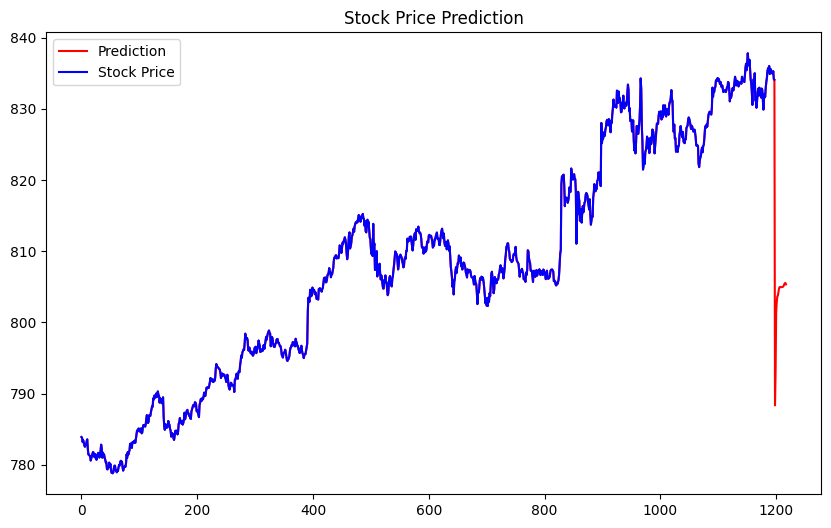

In [ ]:
predictions = [scaler.inverse_transform(y_train[i].reshape(1, -1)) for i in range(len(y_train))]
print(float(predictions[0]))
final_form_results = []
for i in range (len(predictions)):
    final_form_results.append(float(predictions[i]))

for i in range(len(results)):
    final_form_results.append(float(results[i]))

# Build a visualization of the predicted and the real Stock prices of the final_form_results set
plt.figure(figsize=(10, 6))
plt.plot(final_form_results, label='Prediction', color='red')
plt.plot(scaler.inverse_transform(y_train.reshape(-1, 1)), label='Stock Price', color='blue')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()

In [ ]:
print(len(results))
x = [i for i in range(len(y_train) + len(results))]
print(x)

[[783.9004459 ]
 [783.80825145]
 [783.20789058]
 ...
 [835.28782731]
 [834.14966279]
 [834.08600747]]
20
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,

Comment the results. How can you improve your model ? What are the different parameters you can modify ? Implement them. Do you see any change ?

On voit que le modèle ne s'adapte pas du tout à la tendance. 
Je pense qu'il faut rajouter de la complexité à notre modèle et pourquoi pas faire de la data augmentation

En parralèle de changer la structure de notre RNN je ferai osciller les hyperparamêtres tel que le batch size et le learning rate pour voir comment il s'adapte